# Random Regions

**Author:** **[Serge Rey](https://github.com/sjsrey),** **[James Gaboardi](https://github.com/jGaboardi)**

## Introduction

In this notebook we demonstrate how to use `spopt` with empirical and synthetic examples by:

1. Evaluating the properties of a predefined regionalization scheme.
2. Exploring the `max_swaps` parameter on a simple lattice. 

`spopt` offers functionality to generate random regions based on user-defined constraints. There are three optional parameters to constrain the regionalization: number of regions, cardinality, and contiguity. The default case simply takes a list of area IDs and randomly selects the number of regions and then allocates areas to each region. The user can also pass a vector of integers to the cardinality parameter to designate the number of areas to randomly assign to each region. The contiguity parameter takes a spatial weights object and uses that to ensure that each region is made up of spatially contiguous areas. When the contiguity constraint is enforced, it is possible to arrive at infeasible solutions; the `maxiter` parameter can be set to make multiple attempts to find a feasible solution. 

We begin with importing the relevant packages:

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2022-10-18T08:52:32.797678-04:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import inequality
import libpysal
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
import spopt
from spopt.region import RandomRegion, RandomRegions
import warnings

RANDOM_SEED = 12345

%watermark -w
%watermark -iv

Watermark: 2.3.1

matplotlib: 3.6.1
inequality: 1.0.0
pandas    : 1.5.0
json      : 2.0.9
numpy     : 1.23.3
seaborn   : 0.12.0
libpysal  : 4.6.2
geopandas : 0.11.1
spopt     : 0.4.1+200.g336f235.dirty



## 1. Evaluating Regional Partitions: The case of Mexican state incomes

We will be using the built-in example data set `mexico` from the [libpysal](https://pysal.org/libpysal/) package. First, we get a high-level overview of the example:

In [3]:
libpysal.examples.explain("mexico")

mexico

Decennial per capita incomes of Mexican states 1940-2000
--------------------------------------------------------

* mexico.csv: attribute data. (n=32, k=13)
* mexico.gal: spatial weights in GAL format.
* mexicojoin.shp: Polygon shapefile. (n=32)

Data used in Rey, S.J. and M.L. Sastre Gutierrez. (2010) "Interregional inequality dynamics in Mexico." Spatial Economic Analysis, 5: 277-298.



In [4]:
mdf = geopandas.read_file(libpysal.examples.get_path("mexicojoin.shp"))

In [5]:
mdf.head()

,POLY_ID,AREA,CODE,NAME,PERIMETER,ACRES,HECTARES,PCGDP1940,PCGDP1950,PCGDP1960,...,GR9000,LPCGDP40,LPCGDP50,LPCGDP60,LPCGDP70,LPCGDP80,LPCGDP90,LPCGDP00,TEST,geometry
0,1,7.252751e+10,MX02,Baja California Norte,2040312.385,1.792187e+07,7252751.376,22361.0,20977.0,17865.0,...,0.05,4.35,4.32,4.25,4.40,4.47,4.43,4.48,1.0,"MULTIPOLYGON (((-113.13972 29.01778, -113.2405..."
1,2,7.225988e+10,MX03,Baja California Sur,2912880.772,1.785573e+07,7225987.769,9573.0,16013.0,16707.0,...,0.00,3.98,4.20,4.22,4.39,4.46,4.41,4.42,2.0,"MULTIPOLYGON (((-111.20612 25.80278, -111.2302..."
2,3,2.731957e+10,MX18,Nayarit,1034770.341,6.750785e+06,2731956.859,4836.0,7515.0,7621.0,...,-0.05,3.68,3.88,3.88,4.04,4.13,4.11,4.06,3.0,"MULTIPOLYGON (((-106.62108 21.56531, -106.6475..."
3,4,7.961008e+10,MX14,Jalisco,2324727.436,1.967200e+07,7961008.285,5309.0,8232.0,9953.0,...,0.03,3.73,3.92,4.00,4.21,4.32,4.30,4.33,4.0,"POLYGON ((-101.52490 21.85664, -101.58830 21.7..."
4,5,5.467030e+09,MX01,Aguascalientes,313895.530,1.350927e+06,546702.985,10384.0,6234.0,8714.0,...,0.13,4.02,3.79,3.94,4.21,4.32,4.32,4.44,5.0,"POLYGON ((-101.84620 22.01176, -101.96530 21.8..."


This data set records per capital Gross Domestic Product (PCGDP) for the decades 1940-2000 for 32 Mexican states.

In [6]:
mdf.columns

Index(['POLY_ID', 'AREA', 'CODE', 'NAME', 'PERIMETER', 'ACRES', 'HECTARES',
       'PCGDP1940', 'PCGDP1950', 'PCGDP1960', 'PCGDP1970', 'PCGDP1980',
       'PCGDP1990', 'PCGDP2000', 'HANSON03', 'HANSON98', 'ESQUIVEL99', 'INEGI',
       'INEGI2', 'MAXP', 'GR4000', 'GR5000', 'GR6000', 'GR7000', 'GR8000',
       'GR9000', 'LPCGDP40', 'LPCGDP50', 'LPCGDP60', 'LPCGDP70', 'LPCGDP80',
       'LPCGDP90', 'LPCGDP00', 'TEST', 'geometry'],
      dtype='object')

We can plot the spatial distribution of regional incomes in the last decade of the sample:

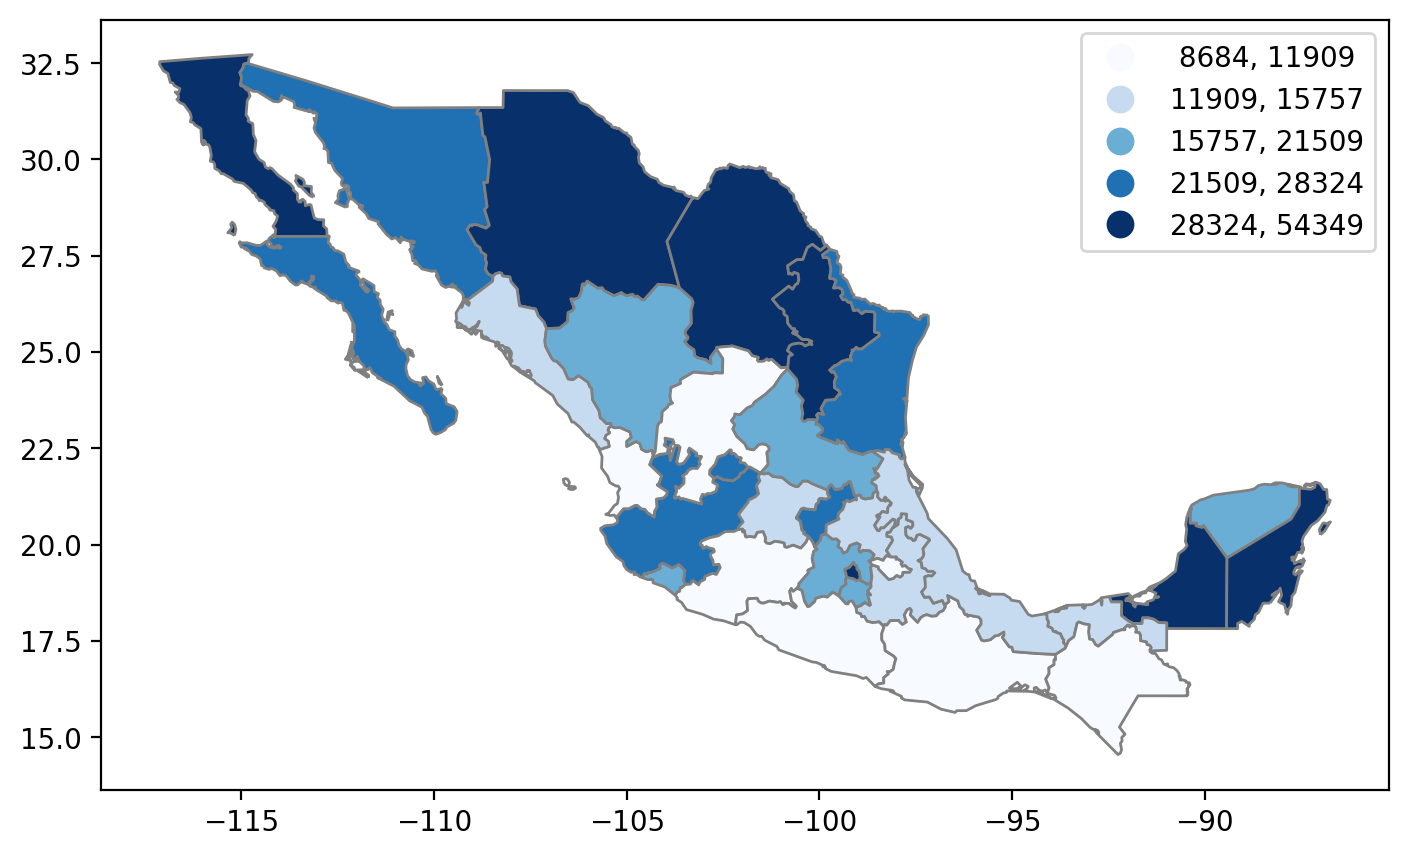

In [7]:
plt.rcParams["figure.figsize"] = [10, 5]
mdf.plot(
    column="PCGDP2000",
    scheme="quantiles",
    cmap="Blues",
    edgecolor="grey",
    legend=True,
    legend_kwds={"fmt": "{:.0f}"},
);

Here we see the north-south divide in the Mexican space economy. This pattern has been the subject of much recent research, and a common methodological strategy in these studies is to *partition* the states into mutually exclusive and exhaustive regions. The motivation is similar to that in traditional clustering where one attempts to group like objects together. Here the regional sets should be composed of states that are more similar to other members of the same set, and distinct from those states in other sets.

Our dataset has a number of regionalization schemes from the published literature. Here we will focus on one `HANSON03`. We can plot this partition using a categorical scheme:

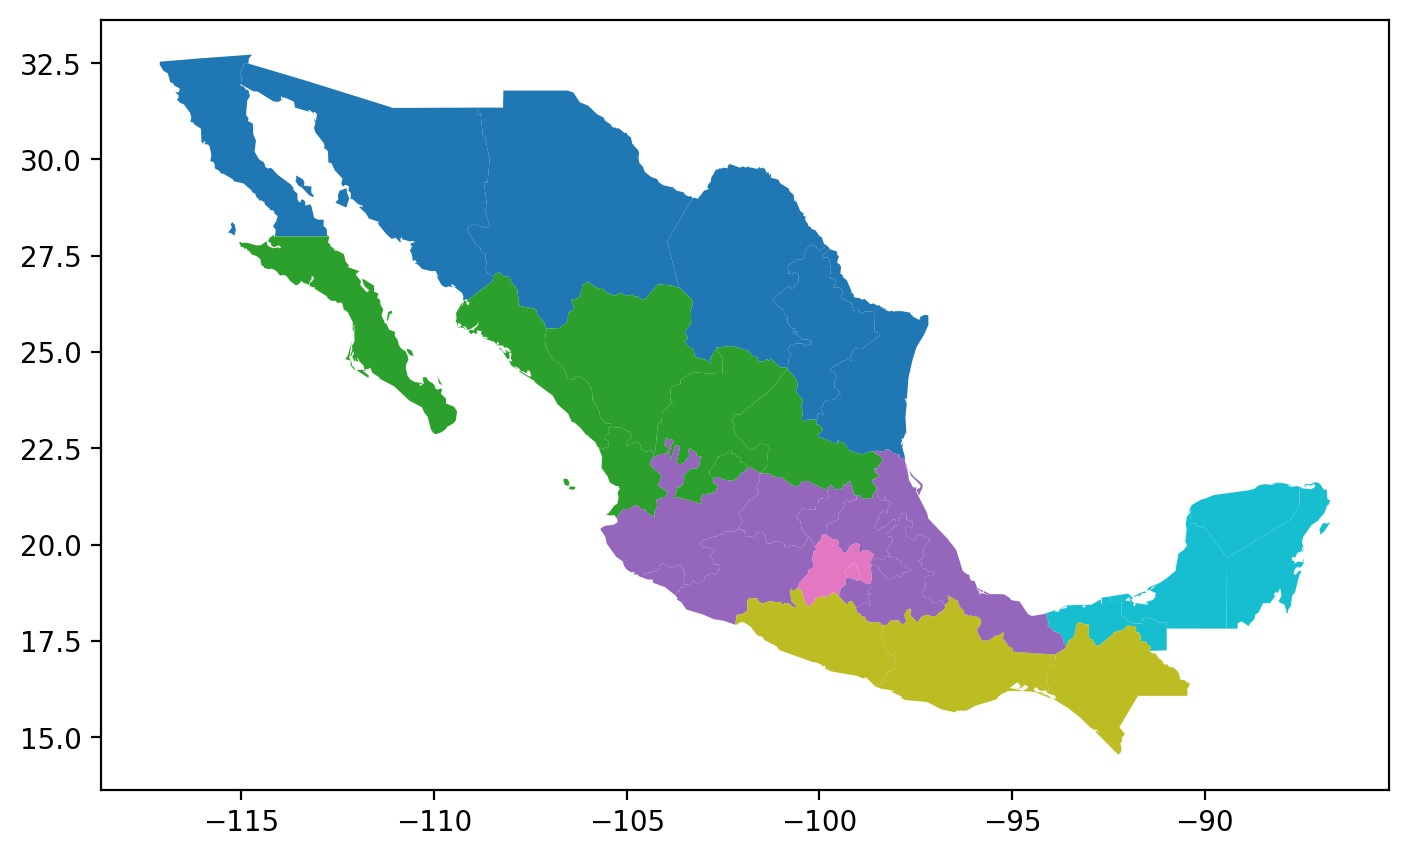

In [8]:
mdf.plot(column="HANSON03", categorical=True);

Here the different colors symbolize membership in a different region. We can examine the cardinality structure of this partition:

In [9]:
cards = mdf.groupby(by="HANSON03").count().NAME.values.tolist()
cards

[6, 7, 10, 2, 3, 4]

Thus, we see there six regions (sets) of different sizes, the smallest region has only two states, while the largest (in a set-theory sense) has 10 states. We can explore the regional definitions in tabular form:

In [10]:
mdf[["NAME", "HANSON03", "PCGDP2000"]].sort_values(by="HANSON03")

,NAME,HANSON03,PCGDP2000
0,Baja California Norte,1.0,29855.0
29,Nuevo Leon,1.0,38672.0
24,Coahuila De Zaragoza,1.0,28460.0
23,Chihuahua,1.0,30735.0
22,Sonora,1.0,24068.0
30,Tamaulipas,1.0,23546.0
1,Baja California Sur,2.0,26103.0
2,Nayarit,2.0,11478.0
4,Aguascalientes,2.0,27782.0
28,San Luis Potosi,2.0,15866.0


## How good is `HANSON03` as a partition?

One question we might ask about the partition, is how good of a job does it do at capturing the spatial distribution of incomes in Mexico? To answer this question, we are going to leverage the random regions functionality in `spopt`.

### A random partition respecting cardinality constraints

We will first create a new random partition that has the same cardinality structure/distribution as the `HANSON03` partition:

In [11]:
ids = mdf.index.values.tolist()

In [12]:
numpy.random.seed(RANDOM_SEED)
rrmx = RandomRegion(ids, num_regions=6, cardinality=cards)

This creates a new `RandomRegion` instance. One of its attributes is the definition of the regions in the partition:

In [13]:
rrmx.regions

[[27, 12, 18, 3, 15, 8],
 [0, 25, 21, 20, 7, 6, 24],
 [23, 10, 13, 11, 19, 16, 26, 14, 17, 22],
 [28, 31],
 [30, 9, 4],
 [1, 29, 5, 2]]

This will have the same cardinality as the `HANSON03` partition:

In [14]:
set([len(region) for region in rrmx.regions]) == set(cards)

True

A simple helper function let's us attach the region labels for this new partition into the dataframe:

In [15]:
def region_labels(df, solution, name="labels_"):
    n, k = df.shape
    labels_ = numpy.zeros((n,), int)
    for i, region in enumerate(solution.regions):
        labels_[region] = i
    df[name] = labels_

And, then we can visualize the new partition:

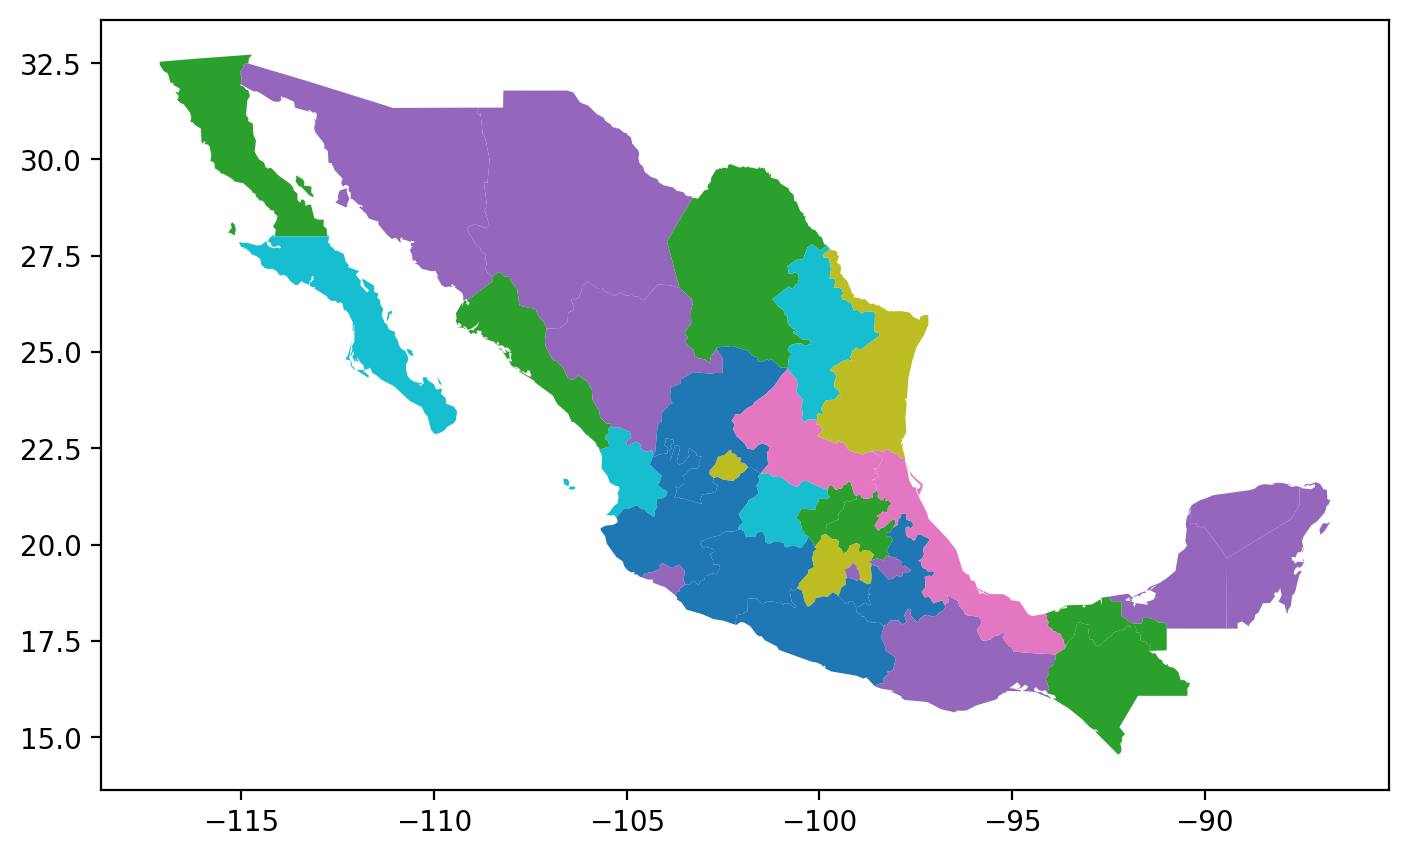

In [16]:
region_labels(mdf, rrmx, name="rrmx")
mdf.plot(column="rrmx", categorical=True);

While the `rrmx` partition and the `HANSON03` partitions have identical cardinality structures, their spatial distributions are radically different. The `rrmx` map looks nothing like the `HANSON03` map.

One of the key differences is that the sets in the `HANSON03` partition are each spatially connected components while this is not the case for the "regions" in the `rrmx` partition.

### A random partition respecting cardinality and contiguity constraints

A second way to form a random partition is to add an additional constraint in the form of the spatial connectivity between the states. To do so, we will construct a spatial weights object using the `Queen` contiguity criterion:

In [17]:
w = libpysal.weights.Queen.from_dataframe(mdf)

and then add this as an additional parameter to instantiate a new `RandomRegion`:

In [18]:
numpy.random.seed(RANDOM_SEED)
rrmxc = RandomRegion(ids, num_regions=6, cardinality=cards, contiguity=w)

In [19]:
rrmxc.regions

[[27, 5, 28, 8, 11, 24, 3, 4, 2, 29],
 [18, 19, 9, 21, 10, 12, 20],
 [0, 22, 1, 25, 23, 26],
 [13, 16, 14],
 [15, 17, 7, 6],
 [31, 30]]

This will also have the same cardinality as the `HANSON03` partition:

In [20]:
set([len(region) for region in rrmxc.regions]) == set(cards)

True

But, more importantly, we see the partition yields spatially connected components for the regions:

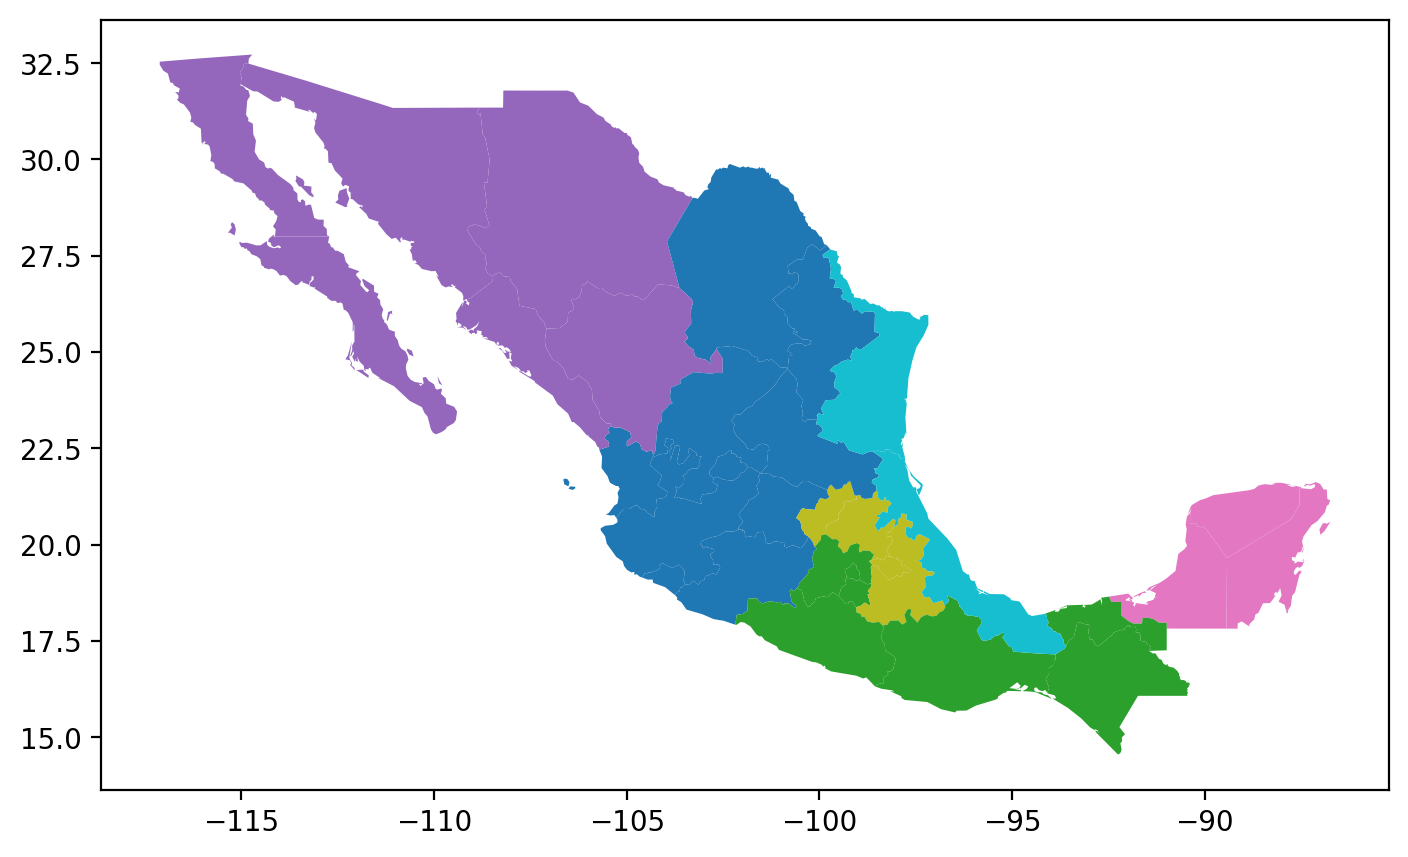

In [21]:
region_labels(mdf, rrmxc, name="rrmxc")
mdf.plot(column="rrmxc", categorical=True);

## Comparing Partitions

We now can get back to the question of how good the `HANSON03` partition does in capturing the spatial structure of state incomes in Mexico. Two alternative random partitions have been constructed using `RandomRegion` and we can compare these with the `HANSON03` partition:

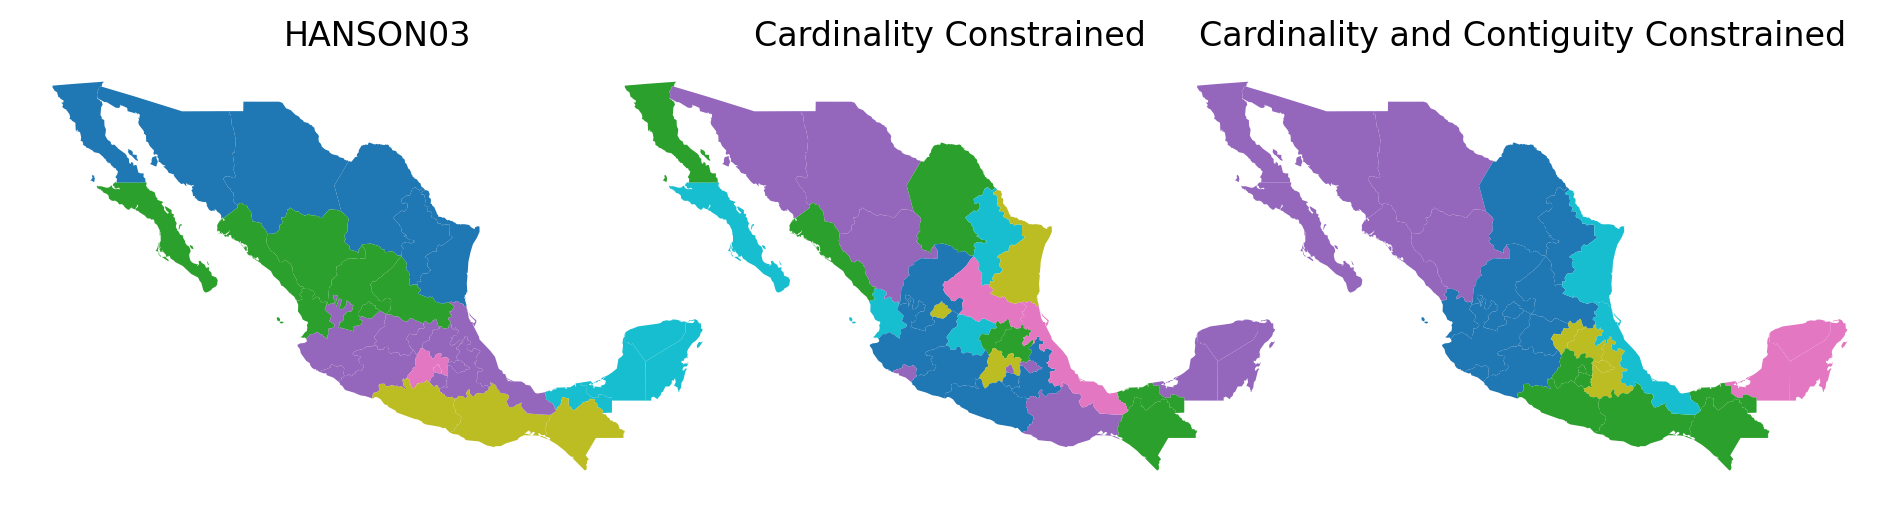

In [22]:
f, axs = plt.subplots(1, 3, figsize=(12, 8))
ax1, ax2, ax3 = axs

mdf.plot(column="HANSON03", categorical=True, ax=ax1)
ax1.set_axis_off()
ax1.set_aspect("equal")
ax1.set_title("HANSON03")

mdf.plot(column="rrmx", categorical=True, ax=ax2)
ax2.set_axis_off()
ax2.set_aspect("equal")
ax2.set_title("Cardinality Constrained")

mdf.plot(column="rrmxc", categorical=True, ax=ax3)
ax3.set_axis_off()
ax3.set_aspect("equal")
ax3.set_title("Cardinality and Contiguity Constrained")

plt.subplots_adjust(wspace=-0.2);

In order to judge the `HANSON03` regions against those from the two random solutions, we need some objective function to serve as our benchmark. Given the interest in the spatial distribution of incomes, we might ask if a partition has minimized the internal heterogeneity of the incomes for states belonging to each set?

We can use the PySAL [inequality](https://inequality.readthedocs.io/en/latest/) package to implement this measure:

Let's focus on the last year in the sample and pull out the state incomes:

In [23]:
y = mdf.PCGDP2000

The [TheilD](https://inequality.readthedocs.io/en/latest/generated/inequality.theil.TheilD.html#inequality.theil.TheilD) statistic decomposes the inequality of the 32 state incomes into two parts:

- inequality between states belonging to different regions (inequality between regions)
- inequality between states belonging to the same region (inequality within regions)

We can calculate this for the original partition:

In [24]:
t_hanson = inequality.theil.TheilD(y, mdf.HANSON03)

The overall level of inequality is:

In [25]:
t_hanson.T

0.10660832349588023

which is decomposed into the "between-regions" component:

In [26]:
t_hanson.bg

array([0.05373534])

and the "within-regions" component:

In [27]:
t_hanson.wg

array([0.05287298])

For this partition, the two components are roughly equal. How does this compare to a random partition? Well, for a random partition with the same cardinality structure as `HANSON03` we can carry out the same decomposition:

In [28]:
t_rrmx = inequality.theil.TheilD(y, mdf.rrmx)

The level of overall inequality will be the same:

In [29]:
t_rrmx.T

0.10660832349588023

However, the decomposition is very different now, with the within component being much larger than the between component.

In [30]:
t_rrmx.bg

array([0.02096667])

In [31]:
t_rrmx.wg

array([0.08564165])

How about when both cardinality and contiguity are taken into account when developing the random partition? We can pass in the partition definition for this solution into the decomposition:

In [32]:
t_rrmxc = inequality.theil.TheilD(y, mdf.rrmxc)

Again, the total inequality remains the same:

In [33]:
t_rrmxc.T

0.10660832349588023

and the within-region component is even larger than either the `HANSON03` and `rrmx` partitions:

In [34]:
t_rrmxc.bg

array([0.01313884])

In [35]:
t_rrmxc.wg

array([0.09346949])

### Generating a Reference Distribution

Both of the comparison partitions are examples of random partitions, subject to matching the cardinality (`rrmx`) or cardinality and contiguity constraints (`rmxc`). As such, the generated partitions should be viewed as samples from the population of all possible random partitions that also respect those constraints. Rather than relying on a single draw from each of these distributions, as we have done up to now, if we sample from these distributions, we can develop an empirical reference distribution to compare the original `HANSON03` partition against. In other words, we can ask if the latter partition is performing any better than a random partition that respects the cardinality and contiguity constraints.

We can do this by adding in a `permutations` argument to the class `RandomRegions`. Note the plural here in that this class is intended to generate `permutations` solutions for the random regions that respect the relevant cardinality and contiguity constraints. We will generate `permutations=99` solutions and calculate the inequality decomposition for each of the 99 partitions, extracting the `wg` component to develop the reference distribution
against which we can evaluate the observed `wg` value from the `HANSON03` partition:

In [36]:
numpy.random.seed(RANDOM_SEED)
rrmxcs = RandomRegions(
    ids, num_regions=6, cardinality=cards, contiguity=w, permutations=99
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    wg = []
    for i, solution in enumerate(rrmxcs.solutions_feas):
        name = f"rrmxc_{i}"
        region_labels(mdf, solution, name=name)
        wg.append(inequality.theil.TheilD(y, mdf[name]).wg)
wg = numpy.array(wg)

The mean of the within-region inequality component is:

In [37]:
wg.mean()

0.08499903576350978

which is larger than the observed value for `HANSON03`:

In [38]:
t_hanson.wg

array([0.05287298])

Examining the empirical distribution of the within-region inequality component for the random partitions:

In [39]:
rdf = pandas.DataFrame(data=wg, columns=["Within-region inequality"])

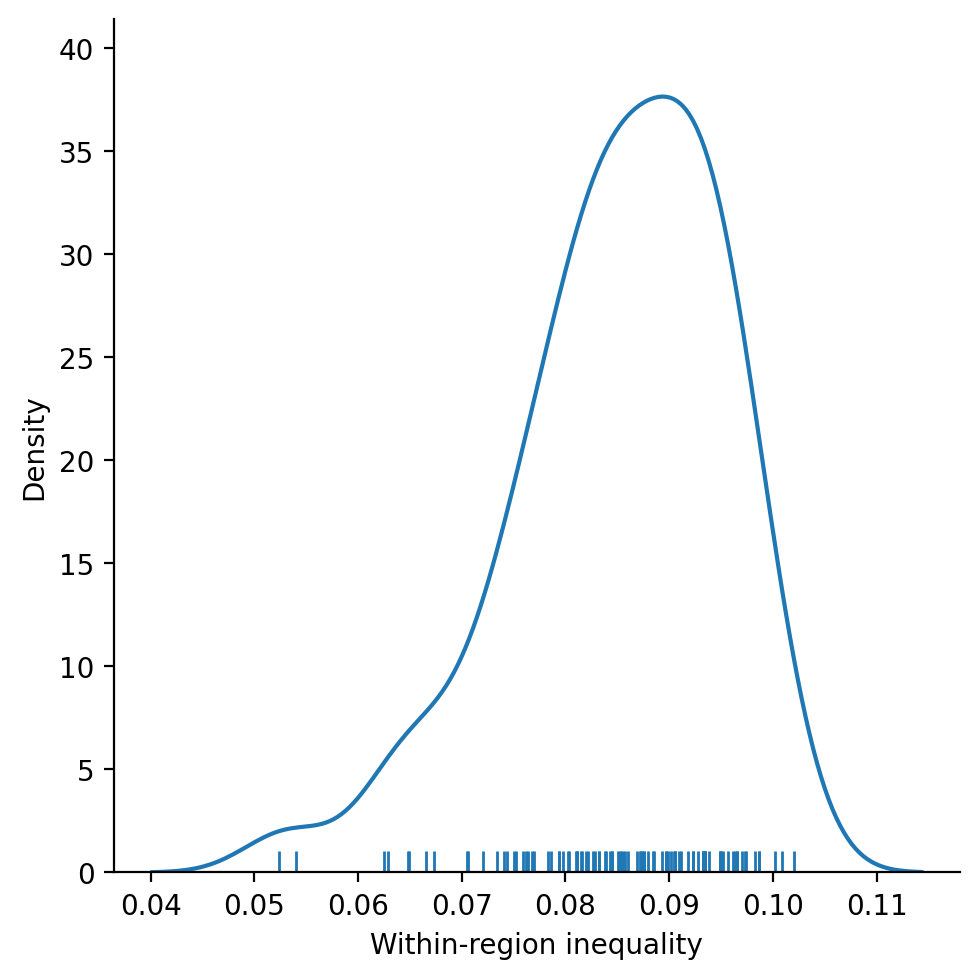

In [40]:
_ = seaborn.displot(
    rdf, kind="kde", legend=False, x="Within-region inequality", rug=True
);

provides a more comprehensive benchmark for evaluating the `HANSON03` partition. We see that the observed within-region component is extreme relative to what we would expect if the partitions were formed randomly subject to the
cardinality and contiguity constraints:

In [41]:
t_hanson.wg

array([0.05287298])

In [42]:
wg.min()

0.05239212313069784

We could even formalize this statement by developing a pseudo p-value for the observed component:

In [43]:
pvalue = (1 + (wg <= t_hanson.wg[0]).sum()) / 100
pvalue

0.02

which would lead us to conclude that the observed value is significantly different from what would be expected under a random region null. 

So, yes,the `HANSON03` partition does appear to be capturing the spatial pattern of incomes in Mexico in the sense that its larger within-region inequality component is not due to random chance.

---------------------------------

## 2. Demonstrating the `max_swaps` parameter

Generate a 20 x 20 lattice in `spenc` with synthetic labels & plot.

In [44]:
hori, vert = 20, 20
n_polys = hori * vert
gdf = spopt.region.spenclib.utils.lattice(hori, vert)
numpy.random.seed(RANDOM_SEED)
gdf["synth_data"] = numpy.random.laplace(100, 10, n_polys)
gdf.head()

,geometry,synth_data
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....",119.606435
1,"POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1....",95.423219
2,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 1....",89.998863
3,"POLYGON ((0.00000 3.00000, 1.00000 3.00000, 1....",91.062546
4,"POLYGON ((0.00000 4.00000, 1.00000 4.00000, 1....",101.455462


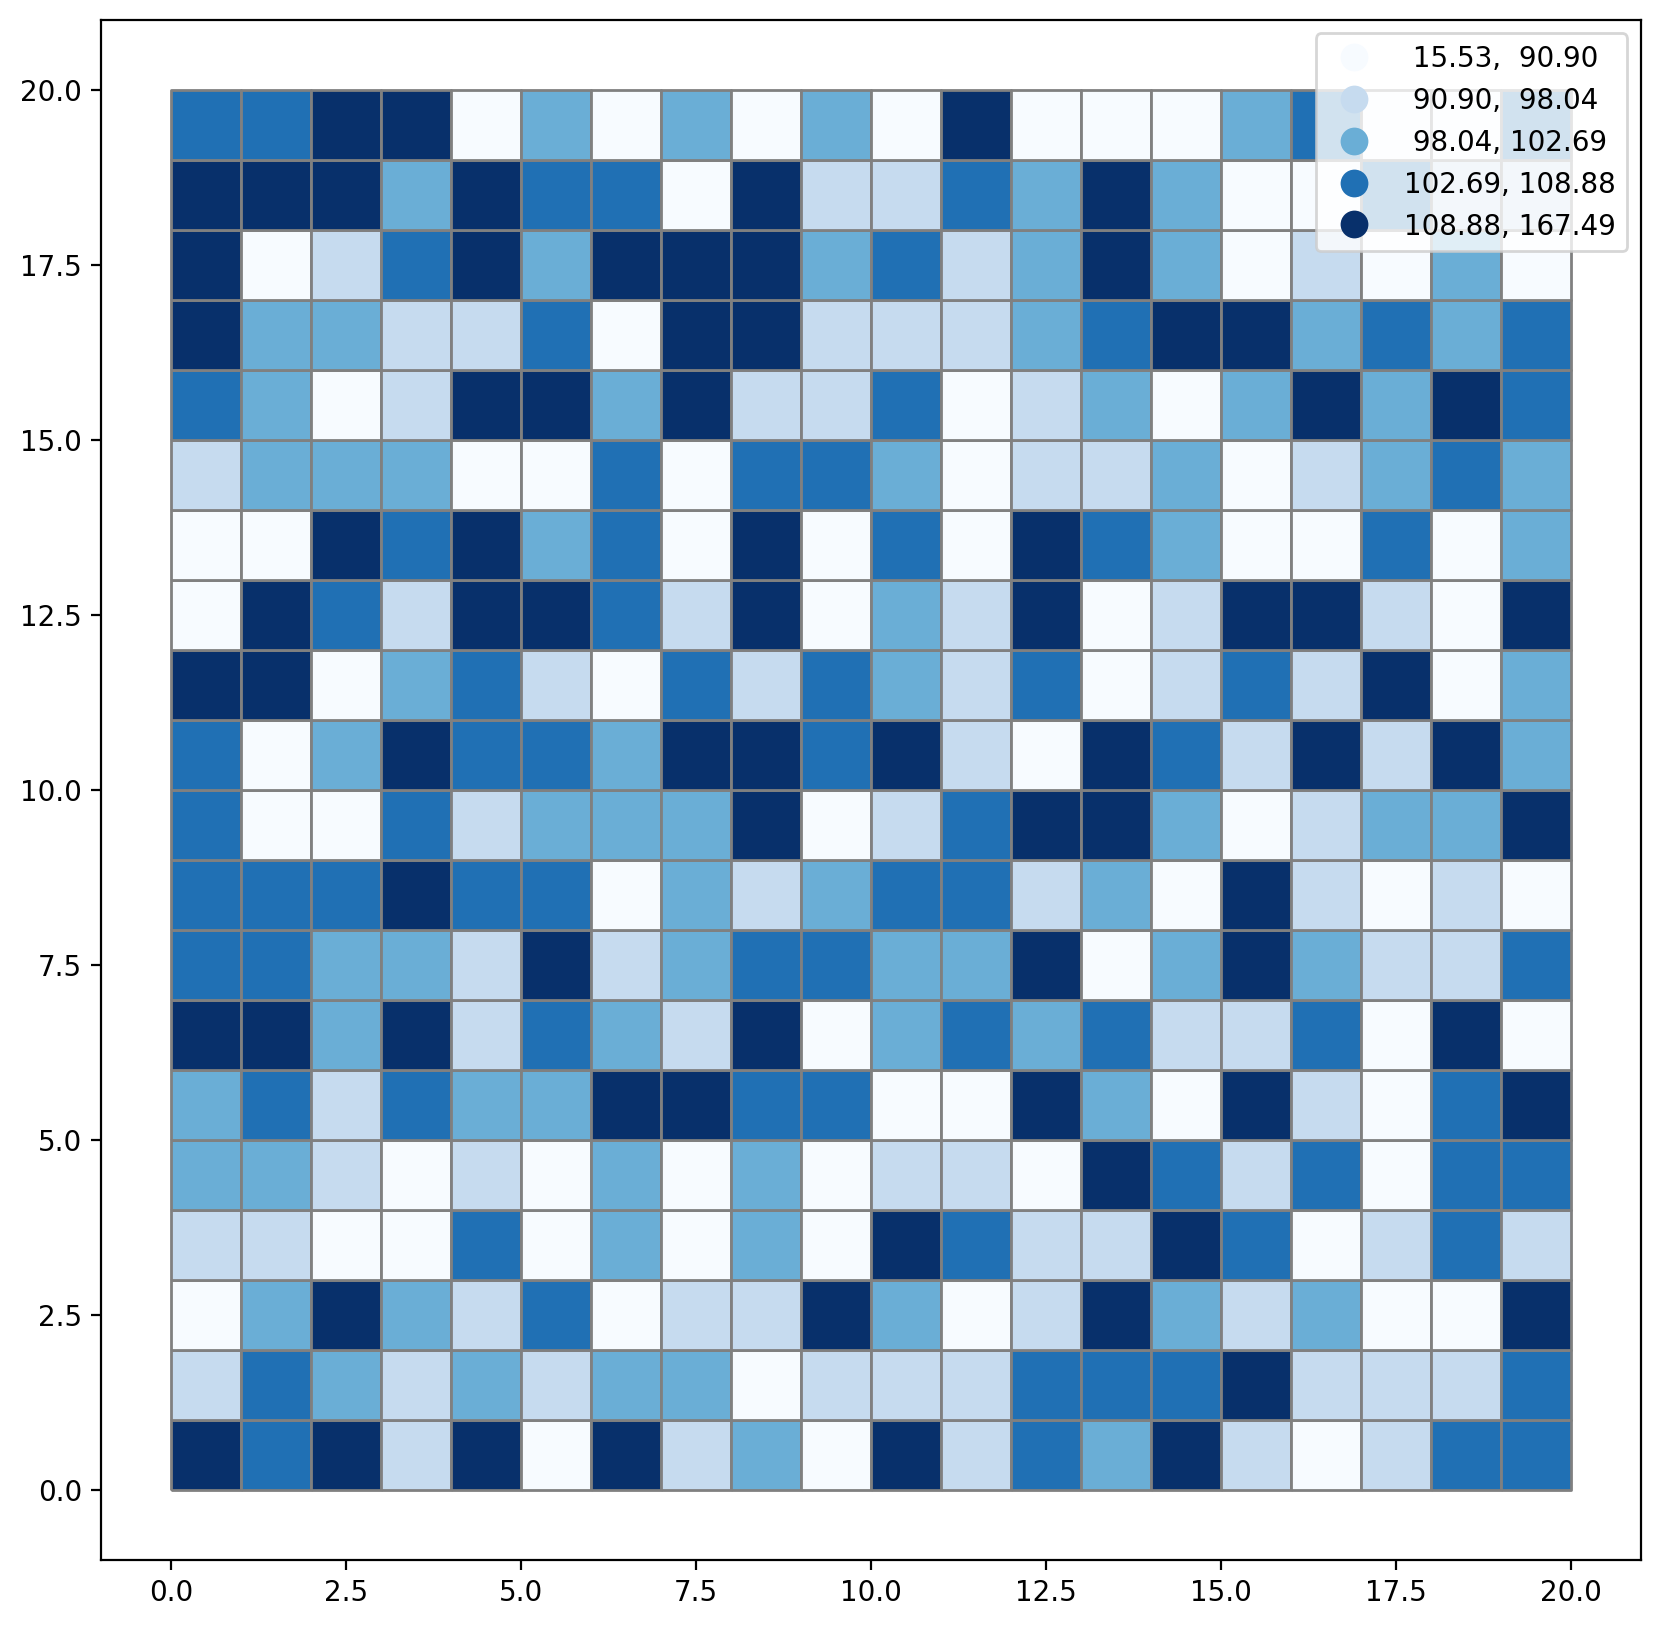

In [45]:
plt.rcParams["figure.figsize"] = [10, 10]
gdf.plot(
    column="synth_data",
    scheme="quantiles",
    cmap="Blues",
    edgecolor="grey",
    legend=True,
    legend_kwds={"fmt": "{:.2f}"},
);

Set the number of desired regions to 4.

In [46]:
n_regions = 4

Define IDs & set cardinality to 100 areas per region.

In [47]:
ids = gdf.index.values.tolist()
cards = [int(n_polys / n_regions)] * n_regions
cards

[100, 100, 100, 100]

Generate a `RandomRegion` instance (constraining only region count and cardinality) and plot.

In [48]:
numpy.random.seed(RANDOM_SEED)
rrlat = RandomRegion(ids, num_regions=n_regions, cardinality=cards)

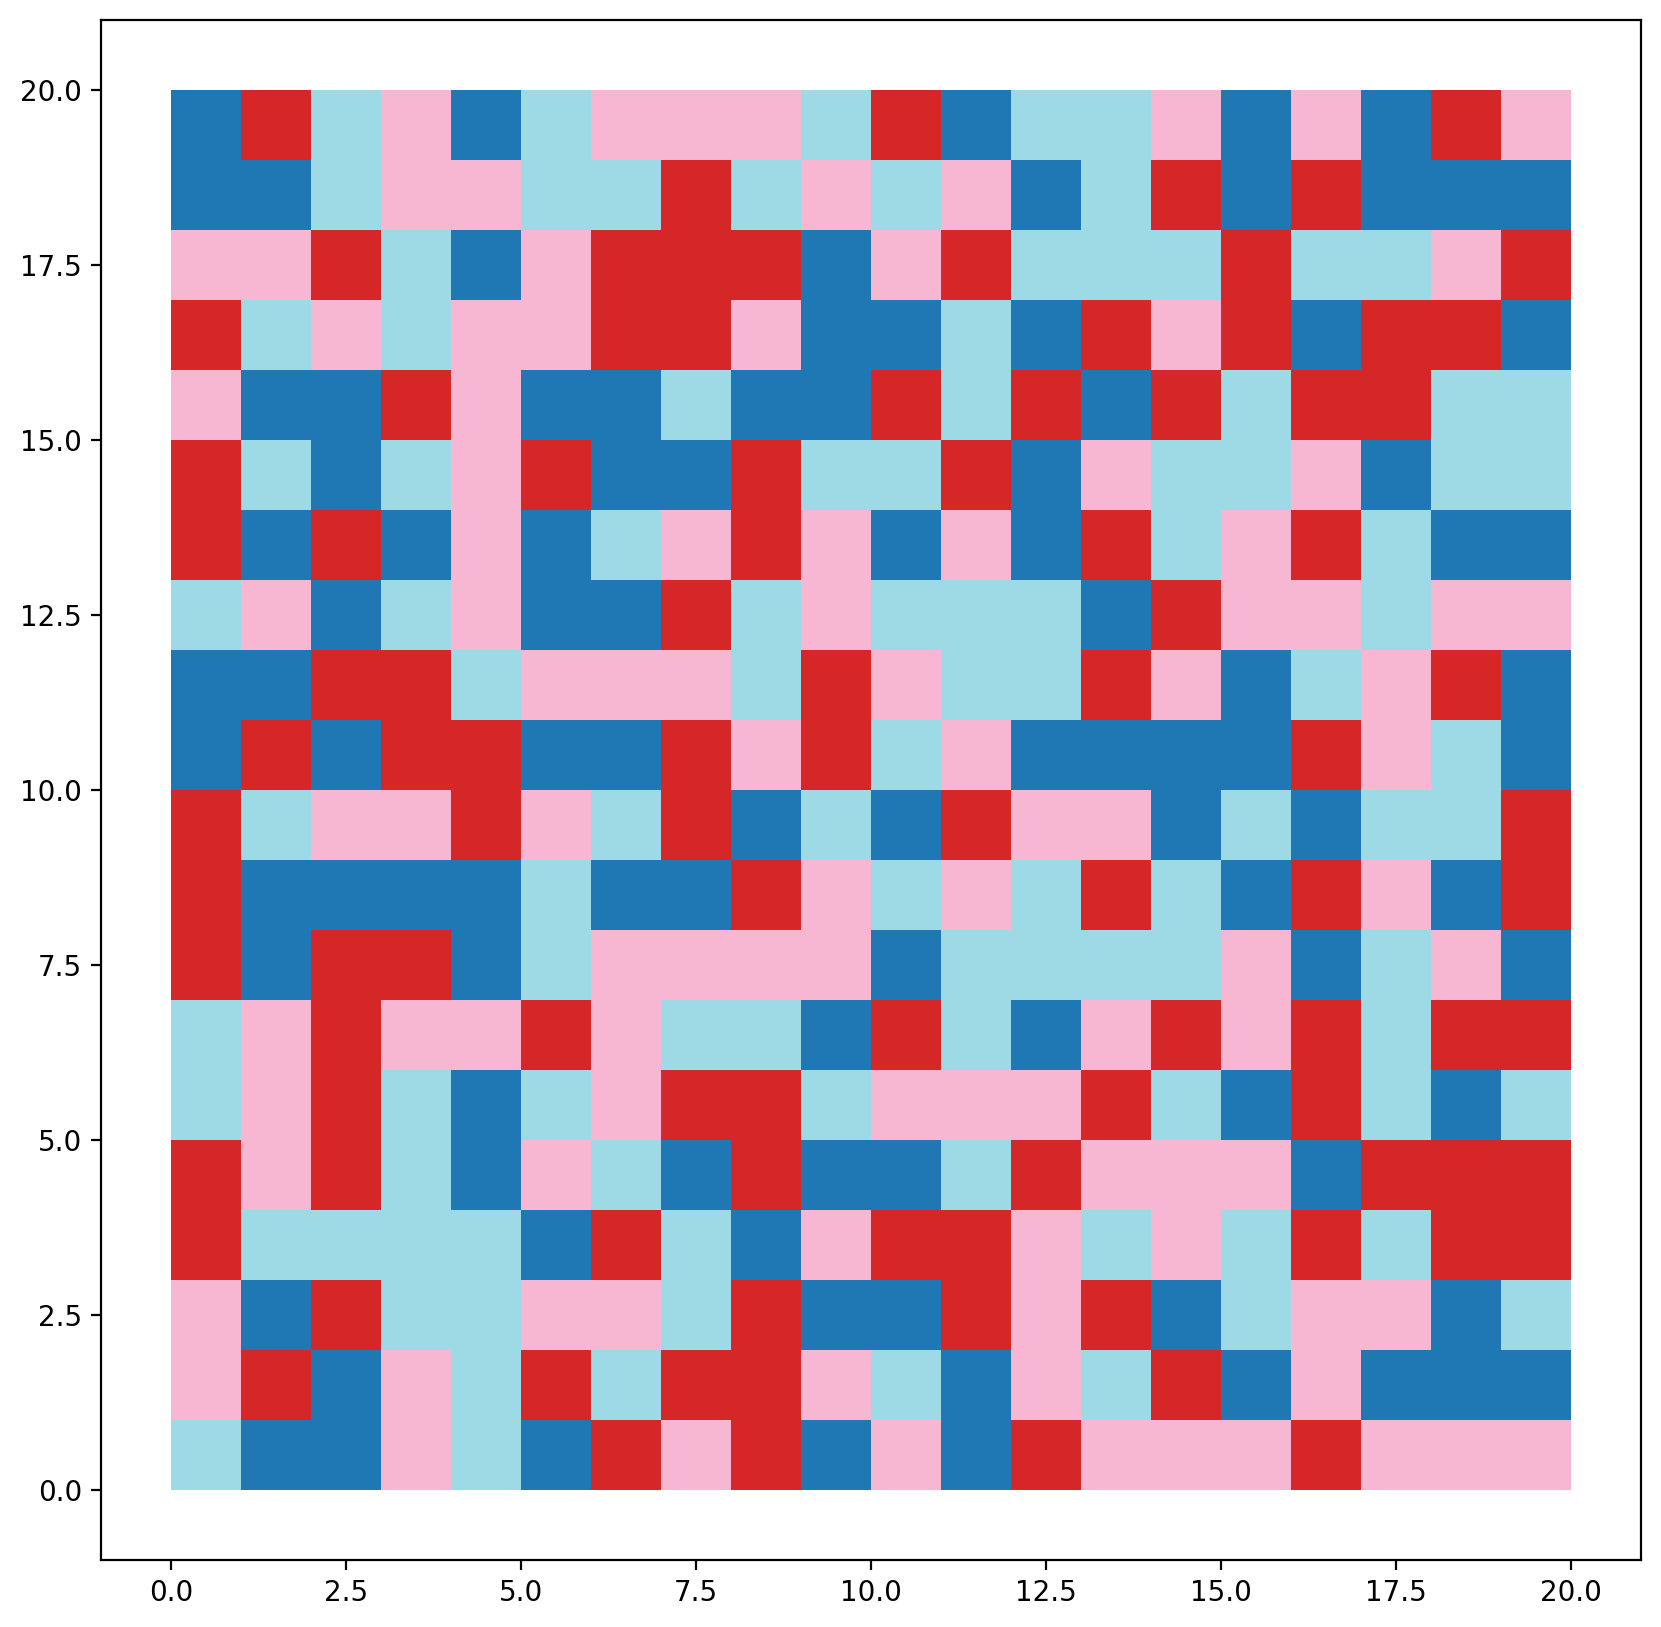

In [49]:
region_labels(gdf, rrlat, name="rrlat")
gdf.plot(column="rrlat", cmap="tab20");

Create a `Queen` weights object to define spatial contiguity.

In [50]:
w = libpysal.weights.Queen.from_dataframe(gdf)

Iterate over `max_swaps=[100, 350, 650, 999]` for 4 `RandomRegion` instances.

In [51]:
for swaps in [100, 350, 650, 999]:
    swap_str = f"rrlatms{swaps}"
    numpy.random.seed(RANDOM_SEED)
    result = RandomRegion(
        ids,
        num_regions=n_regions,
        cardinality=cards,
        contiguity=w,
        compact=True,
        max_swaps=swaps,
    )
    region_labels(gdf, result, name=swap_str)

Assign labels and titles, then plot.

In [52]:
labels = [
    ["synth_data", "rrlatms100", "rrlatms650"],
    ["rrlat", "rrlatms350", "rrlatms999"],
]
titles = [
    ["Data", "Max 100 Swaps", "Max 650 Swaps"],
    ["Unconstrained", "Max 350 Swaps", "Max 999 Swaps"],
]

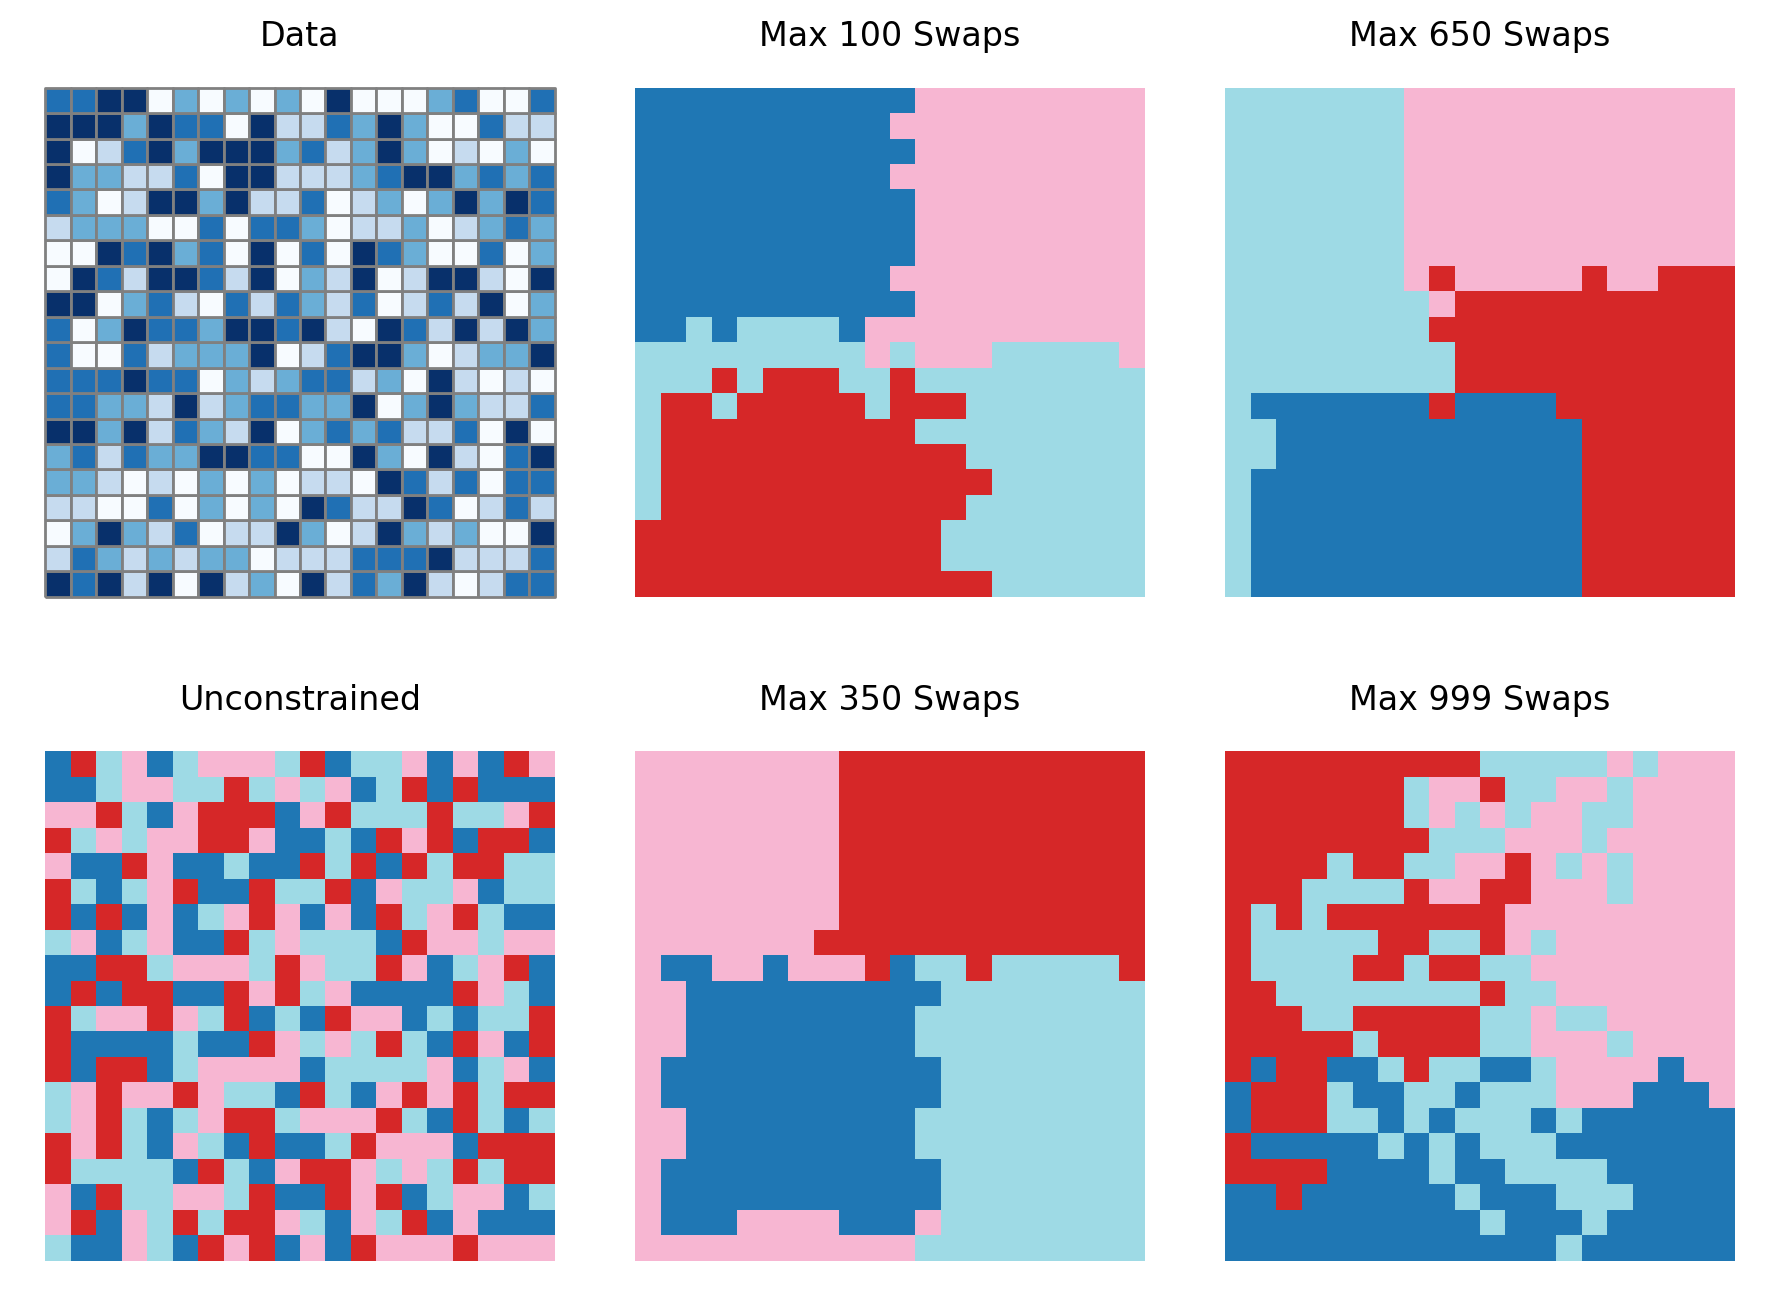

In [53]:
rows, cols = 2, 3
f, axs = plt.subplots(rows, cols, figsize=(9, 7.5))
for i in range(rows):
    for j in range(cols):
        label, title = labels[i][j], titles[i][j]
        _ax = axs[i, j]
        if i == j and i == 0:
            kws = {"scheme": "quantiles", "cmap": "Blues", "ec": "grey"}
            gdf.plot(column=label, ax=_ax, **kws)
        else:
            gdf.plot(column=label, ax=_ax, cmap="tab20")
        _ax.set_title(title)
        _ax.set_axis_off()
        _ax.set_aspect("equal")
plt.subplots_adjust(wspace=1, hspace=0.5)
plt.tight_layout()

As shown here, the results obtained from setting the maximum number of swaps clearly vary.

--------------------------------